## 1. Data preprocessing (lab 1)

In [61]:
import pickle
from dataclasses import dataclass
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from ucimlrepo import fetch_ucirepo


@dataclass
class Data:
    X_train: np.ndarray
    X_test: np.ndarray
    y_train: np.ndarray
    y_test: np.ndarray


def get_data(offline: bool = False) -> Data:
    """Returns preprocessed (X_train, X_test, y_train, y_test)."""
    if not offline:
        heart_disease = fetch_ucirepo(id=45)
    else:
        pickle_file = Path.cwd().parents[1] / "data" / "heart_disease.pkl"
        with open(pickle_file, 'rb') as picklefile:
            heart_disease = pickle.load(picklefile)

    original_df = heart_disease.data.features
    cat_features = ["sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal"]
    num_features = ["age", "trestbps", "chol", "thalach", "oldpeak"]

    # Prepare categorical data
    imputer = SimpleImputer(strategy="most_frequent")
    original_df.loc[:, cat_features] = imputer.fit_transform(original_df[cat_features])
    encoder = OneHotEncoder(categories="auto", sparse_output=False)
    encoded_cat_data = encoder.fit_transform(original_df[cat_features])
    encoded_features = encoder.get_feature_names_out(cat_features)
    original_df[encoded_features] = pd.DataFrame(
        encoded_cat_data, columns=encoded_features
    )

    # Prepare numerical data
    scaler = MinMaxScaler()
    scaled_num_data = scaler.fit_transform(original_df[num_features])
    original_df[num_features] = pd.DataFrame(scaled_num_data, columns=num_features)

    # Convert DataFrame to feature matrix
    original_df = original_df.drop(columns=cat_features)
    X = original_df.to_numpy()

    # Prepare binary target data
    y = heart_disease.data.targets.to_numpy()
    y_binary = np.where(y >= 1, 1, 0)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y_binary, test_size=0.2, random_state=42
    )

    return Data(X_train, X_test, y_train, y_test)

### Data type adapter (np.float -> torch.float)

In [62]:
import torch
from torch.utils.data import Dataset


class HeartDiseaseDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.FloatTensor(features)
        self.labels = torch.FloatTensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

## 2. Model (PyTorch)

In [63]:
from dataclasses import dataclass

import torch.nn as nn


@dataclass
class HiddenLayerConfig:
    neurons: int
    f_activ: nn.Module


class HeartDiseaseClassifier(nn.Module):
    """Heart disease classifier that inherits from torch.nn.Module.

    Architecture:
    - Input layer contains `input_features` neurons.
    - N hidden layers, each with `hidden_layers_config[i].neurons` neurons and
        `hidden_layers_config[i].f_activ` activation function.
    - Output layer: 1 neuron with sigmoid activation function.
    """
    def __init__(
        self,
        input_features: int,
        hidden_layers_config: list[HiddenLayerConfig]
    ):
        super().__init__()
        layers = []
        for i in range(len(hidden_layers_config)):
            input_size = input_features if i == 0 else hidden_layers_config[i-1].neurons
            layers.append(nn.Linear(input_size, hidden_layers_config[i].neurons))
            layers.append(hidden_layers_config[i].f_activ)
        layers.append(nn.Linear(hidden_layers_config[-1].neurons, 1))
        layers.append(nn.Sigmoid())
        self.layers = nn.Sequential(*layers)

        # Init weights
        self.layers.apply(self._init_weights)

    def _init_weights(self, module: nn.Module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            nn.init.zeros_(module.bias)

    def forward(self, x):
        return self.layers(x)


### Training

In [65]:
from sklearn.metrics import accuracy_score, f1_score, recall_score
from torch.nn.modules import Module
from torch.optim.optimizer import Optimizer
from torch.utils.data import DataLoader


def train_one_epoch(
    model: HeartDiseaseClassifier,
    train_loader: DataLoader,
    loss_fn: Module,
    optimizer: Optimizer
):
    for i, (inputs, labels) in enumerate(train_loader):
        # Zero gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()


def train_model(
    model: HeartDiseaseClassifier,
    max_epochs: int,
    train_loader: DataLoader,
    val_loader: DataLoader,
    loss_fn: Module,
    optimizer: Optimizer,
    debug: bool = False
):
    results = []
    prev_avg_val_loss = 0.0
    # Initialize training
    for epoch in range(max_epochs):
        model.train()  # Set model to training mode

        # Train for one epoch
        train_one_epoch(
            model=model,
            train_loader=train_loader,
            loss_fn=loss_fn,
            optimizer=optimizer,
        )

        model.eval()
        running_val_loss = 0.0
        all_labels = []
        all_preds = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                val_loss = loss_fn(outputs, labels)
                running_val_loss += val_loss.item()

                # Binary predictions based on threshold 0.5
                binary_preds = (outputs >= 0.5).float()
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(binary_preds.cpu().numpy())

        # Calculate metrics for the epoch
        accuracy = accuracy_score(all_labels, all_preds)
        recall = recall_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds)
        avg_val_loss = running_val_loss / len(val_loader)

        results.append({
            "accuracy": accuracy,
            "recall": recall,
            "f1": f1,
            "cost": avg_val_loss
        })

        delta = avg_val_loss - prev_avg_val_loss
        if debug:
            print(f"Epoch [{epoch+1}/{max_epochs}] - avg val loss: {avg_val_loss:.4f} (delta: {delta})")
        prev_avg_val_loss = avg_val_loss

    print("Training complete!")
    return results


### Visualizations

In [66]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.axes import Axes


def plot_metrics(results: list[dict[str, float]]):
    x = [i for i in range(len(results))]
    accuracy = [results[i]['accuracy'] for i in x]
    recall = [results[i]['recall'] for i in x]
    f1 = [results[i]['f1'] for i in x]

    plt.figure(figsize=(8, 6))
    plt.plot(x, accuracy, linestyle='-', color='b', label='Accuracy')
    plt.plot(x, recall, linestyle='-', color='r', label='Recall')
    plt.plot(x, f1, linestyle='-', color='g', label='F1 Score')

    plt.xlabel('Epoch')
    plt.ylabel('Metric score')
    plt.title('Plot of metric scores')

    plt.xlim(0, len(results))

    plt.legend()

    plt.grid(True)
    plt.show()


def plot_cost(results: list[dict[str, float]]):
    x = [i for i in range(len(results))]
    cost = [results[i]['cost'] for i in x]

    plt.figure(figsize=(8, 6))
    plt.plot(x, cost, linestyle='-', color='r', label='Cost')

    plt.xlabel('Epoch')
    plt.ylabel('Cost function value')
    plt.title('Plot of cost value over time (epochs)')

    plt.xlim(0, len(results))

    plt.legend()

    plt.grid(True)
    plt.show()


def compare_plots(results_with_titles: list[tuple[dict, str]], cost: bool = False):
    count = len(results_with_titles)
    # cols = min(count, 3)
    # rows = ((count - 1) // 3) + 1
    cols = min(count, 2)
    rows = ((count - 1) // 2) + 1

    fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(rows):
        for j in range(cols):
            ax: Axes = axs[i][j] if rows > 1 else axs[j]
            # if (3 * i) + j < count:
            if (2 * i) + j < count:
                # res, title = results_with_titles[(3 * i) + j]
                res, title = results_with_titles[(2 * i) + j]
                x = [k for k in range(len(res))]
                if cost:
                    cost = [res[j]['cost'] for j in x]
                    ax.plot(x, cost, linestyle='-', color='r', label='Cost')
                else:
                    accuracy = [res[j]['accuracy'] for j in x]
                    recall = [res[j]['recall'] for j in x]
                    f1 = [res[j]['f1'] for j in x]
                    ax.plot(x, accuracy, linestyle='-', color='b', label='Accuracy')
                    ax.plot(x, recall, linestyle='-', color='r', label='Recall')
                    ax.plot(x, f1, linestyle='-', color='g', label='F1 Score')
                    ax.set_ylim(0, 1)
                ax.set_title(title)
                ax.set_xlim(0, len(res))
                ax.legend()
                ax.grid(True)
            else:
                ax.set_visible(False)

    fig.supxlabel('Epoch', fontsize=12)
    if cost:
        fig.supylabel('Cost function value', fontsize=12)
        fig.suptitle('Plot of cost value over time (epochs)', fontsize=14)
    else:
        fig.supylabel('Metric scores', fontsize=12)
        fig.suptitle('Plot of metric scores over time (epochs)', fontsize=14)

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

## 3. Base model (starting point)

Training complete!


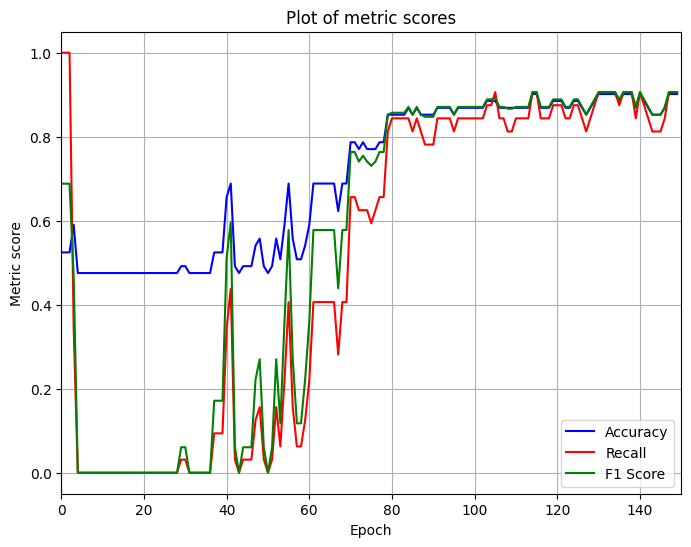

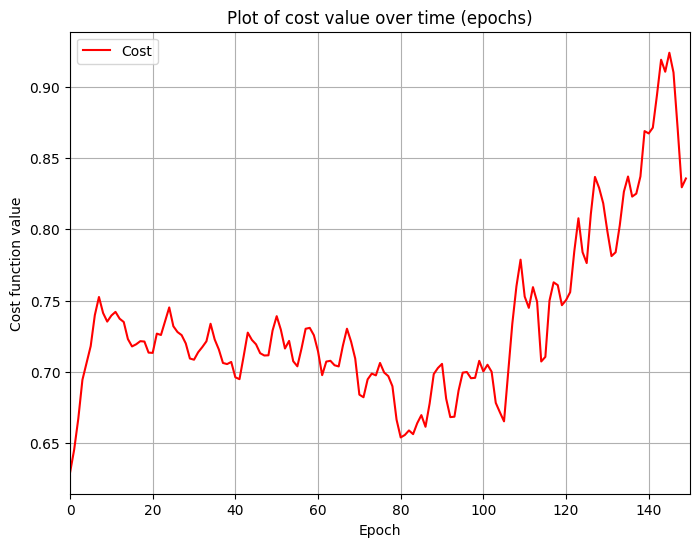

In [6]:
import torch.nn as nn

BATCH_SIZE = 30

data = get_data(offline=True)

train_dataset = HeartDiseaseDataset(data.X_train, data.y_train)
val_dataset = HeartDiseaseDataset(data.X_test, data.y_test)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

model = HeartDiseaseClassifier(
    input_features=data.X_train.shape[1],
    hidden_layers_config=[
        HiddenLayerConfig(14, nn.Sigmoid()),
        HiddenLayerConfig(7, nn.Sigmoid())
    ]
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.0065, momentum=0.9)

results = train_model(
    model=model,
    max_epochs=150,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=nn.BCELoss(),
    optimizer=optimizer,
    # tb_writer: SummaryWriter = None
)

plot_metrics(results)
plot_cost(results)

### Note

The experiment presented above confirms the thesis stated in the last lab - the network with 2 hidden layers is overcomplicated for this particular binary classification. Even with carefully chosen hiper-parameters (size of each layer, learning rate) we can see that the model can hardly reach the expected metric values, and when it finally does - overfitting is already present. That's why in the following experiments we will stick to the network with only a single hidden layer (of size ~12 neurons) and a learning rate of ~0.0012. The following graphs show the performance of a network with such hyperparameters, which is actually quite good: the metric scores reach almost 0.85, while the cost oscillates between 0.68-0.72 and doesn't show any significant overfitting symptoms.

Training complete!


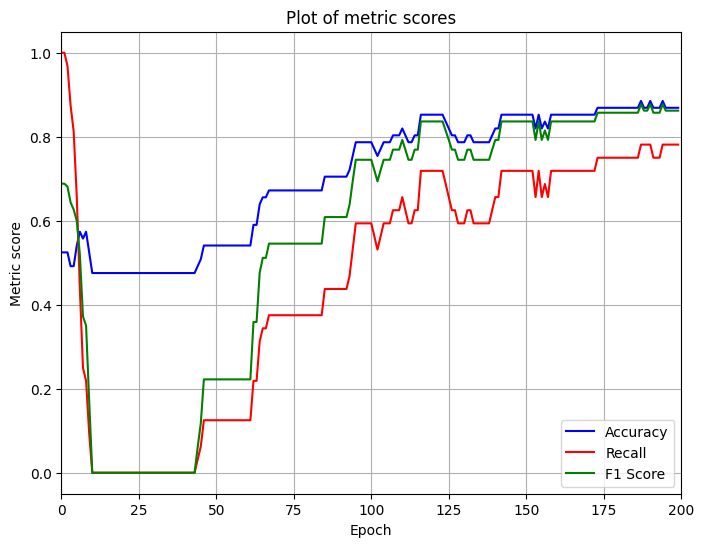

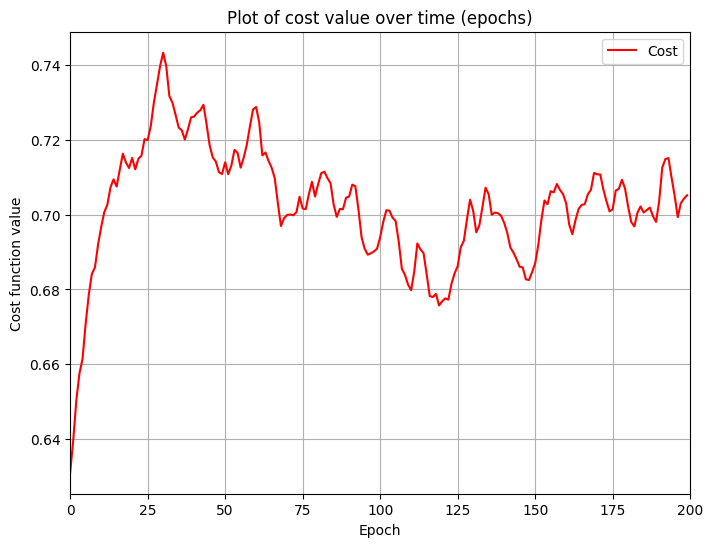

In [71]:
import torch.nn as nn

BATCH_SIZE = 30

data = get_data(offline=True)

train_dataset = HeartDiseaseDataset(data.X_train, data.y_train)
val_dataset = HeartDiseaseDataset(data.X_test, data.y_test)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

model = HeartDiseaseClassifier(
    input_features=data.X_train.shape[1],
    hidden_layers_config=[
        HiddenLayerConfig(12, nn.Sigmoid())
    ]
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.0012, momentum=0.9)

results = train_model(
    model=model,
    max_epochs=200,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=nn.BCELoss(),
    optimizer=optimizer,
)

plot_metrics(results)
plot_cost(results)

## 4. Experiments

### 1. Optimizer (SGD vs Adam vs AdamW)

In [49]:
import torch.nn as nn

BATCH_SIZE = 30

data = get_data(offline=True)

train_dataset = HeartDiseaseDataset(data.X_train, data.y_train)
val_dataset = HeartDiseaseDataset(data.X_test, data.y_test)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

model_sgd = HeartDiseaseClassifier(
    input_features=data.X_train.shape[1],
    hidden_layers_config=[
        HiddenLayerConfig(12, nn.Sigmoid())
    ]
)
optimizer_sgd = torch.optim.SGD(model_sgd.parameters(), lr=0.0012, momentum=0.9)
results_sgd = train_model(
    model=model_sgd,
    max_epochs=150,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=nn.BCELoss(),
    optimizer=optimizer_sgd,
)

model_adam = HeartDiseaseClassifier(
    input_features=data.X_train.shape[1],
    hidden_layers_config=[
        HiddenLayerConfig(12, nn.Sigmoid())
    ]
)
optimizer_adam = torch.optim.Adam(model_adam.parameters(), lr=0.0012)
results_adam = train_model(
    model=model_adam,
    max_epochs=150,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=nn.BCELoss(),
    optimizer=optimizer_adam,
)

model_adamw = HeartDiseaseClassifier(
    input_features=data.X_train.shape[1],
    hidden_layers_config=[
        HiddenLayerConfig(12, nn.Sigmoid())
    ]
)
optimizer_adamw = torch.optim.AdamW(model_adamw.parameters(), lr=0.0012)
results_adamw = train_model(
    model=model_adamw,
    max_epochs=150,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=nn.BCELoss(),
    optimizer=optimizer_adamw,
)

Training complete!
Training complete!
Training complete!


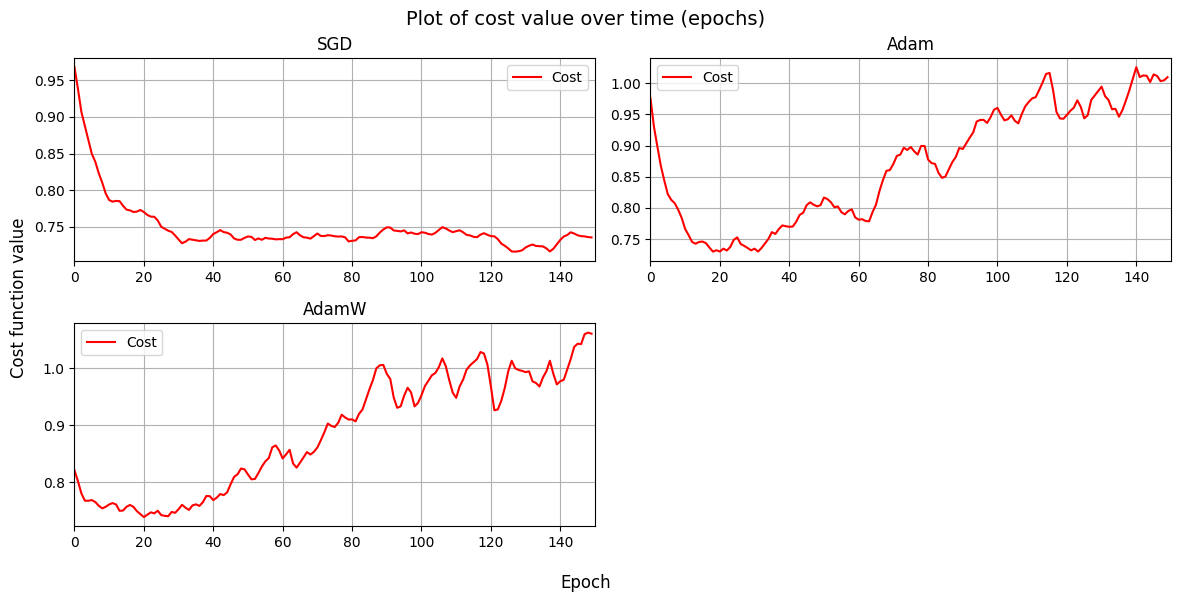

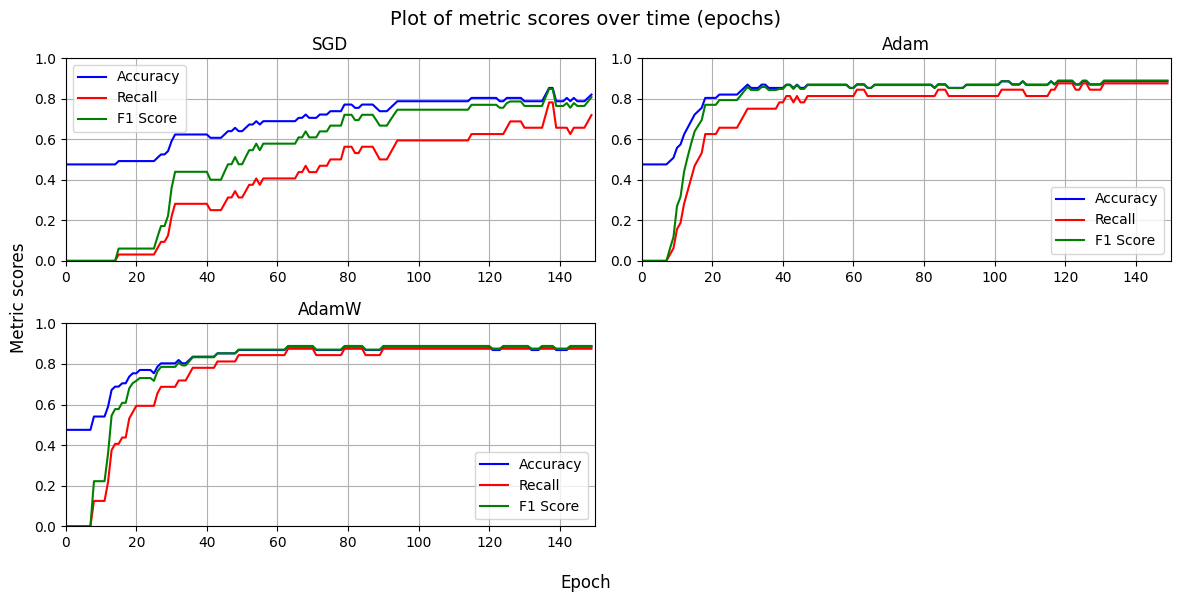

In [50]:
results_with_titles = [
    (results_sgd, "SGD"),
    (results_adam, "Adam"),
    (results_adamw, "AdamW")
]
compare_plots(results_with_titles, cost=True)
compare_plots(results_with_titles, cost=False)

#### Analysis

Looking at both the cost and metric plots, we can say that the choice of optimizer is very important. In the experiment, when all 3 optimizers had almost the same hiperparameters (learning rate = 0.0012, rest set to default, only SGD had a momentum set to not get stuck in some local optimum):  

- `SGD with momentum` showed the most stable behaviour. It had a steadily decreasing cost and a gradual improvement in metrics. It took the longest to reach high metric scores, but they were also not the best (compared to the other optimizers).
- `Adam` had the fastest initial convergence in metric scores and reached the best results at about 30 epochs without being overfitted. Then the cost values increased and the rest of the training was deepened this overfitting. Probably the learning rate was too fast in this case.
- `AdamW` performed quite similarly to Adam in this experiment, so further analysis is needed to see some differences between these optimizers.  

### 2. Batch size

Training complete!
Training complete!
Training complete!
Training complete!


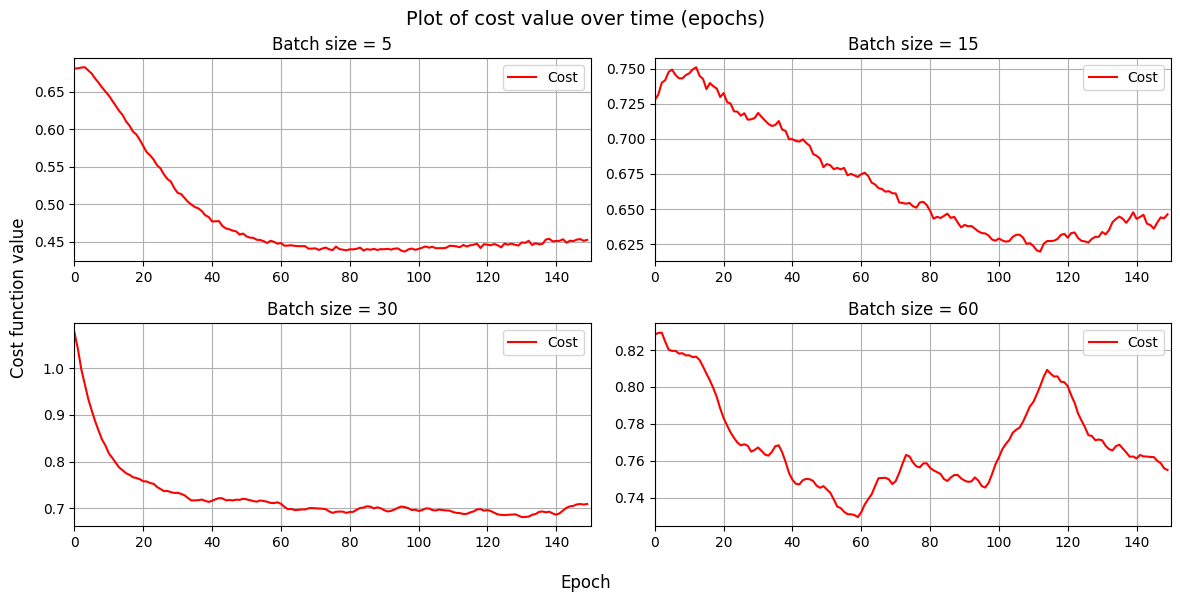

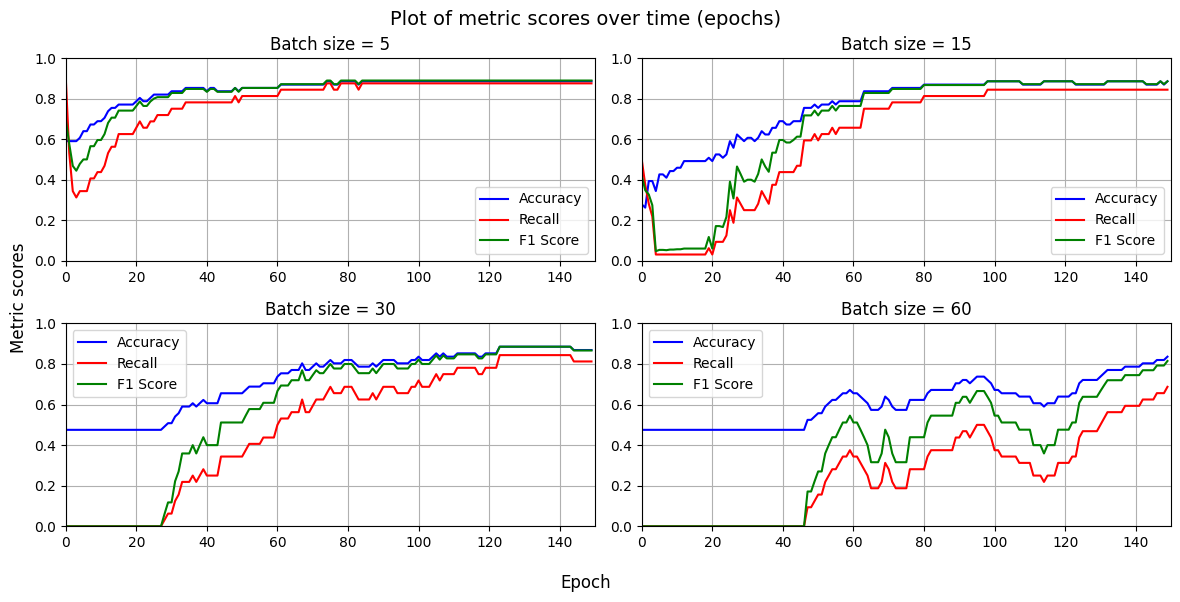

In [ ]:
import torch.nn as nn

data = get_data(offline=True)
train_dataset = HeartDiseaseDataset(data.X_train, data.y_train)
val_dataset = HeartDiseaseDataset(data.X_test, data.y_test)


def test_batch_size(sizes: list[int]) -> list[tuple[dict, str]]:
    results_with_titles = []
    for size in sizes:
        train_loader = DataLoader(train_dataset, batch_size=size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=size)
        model = HeartDiseaseClassifier(
            input_features=data.X_train.shape[1],
            hidden_layers_config=[
                HiddenLayerConfig(12, nn.Sigmoid())
            ]
        )
        optimizer_sgd = torch.optim.SGD(model.parameters(), lr=0.0012, momentum=0.9)
        results = train_model(
            model=model,
            max_epochs=150,
            train_loader=train_loader,
            val_loader=val_loader,
            loss_fn=nn.BCELoss(),
            optimizer=optimizer_sgd,
        )
        results_with_titles.append((results, f"Batch size = {size}"))
    return results_with_titles


results_with_titles = test_batch_size(sizes=[5, 15, 30, 60])
compare_plots(results_with_titles, cost=True)
compare_plots(results_with_titles)

#### Analysis

Based on these training plots we can say that:

- `batch size = 5` achieved the best performance ever seen (in my experiments) - converging smoothly with a steadily decreasing cost values, achieving cost function ~0.45 and showing no significant overfitting symptoms. The metric scores were also very high in the end (~0.9)
- `batch sizes in {15, 30}` performed similarly - stable convergence, high metric scores, not much overfitting symptoms (we can observe this in the last epochs of training with batch size set to 15)
- `batch size = 60` shows really poor performance compared to the other models, was unstable and fluctuated in every metric. This value was definitely too high for this problem.

### 3. Learning rate


Training complete!
Training complete!
Training complete!
Training complete!


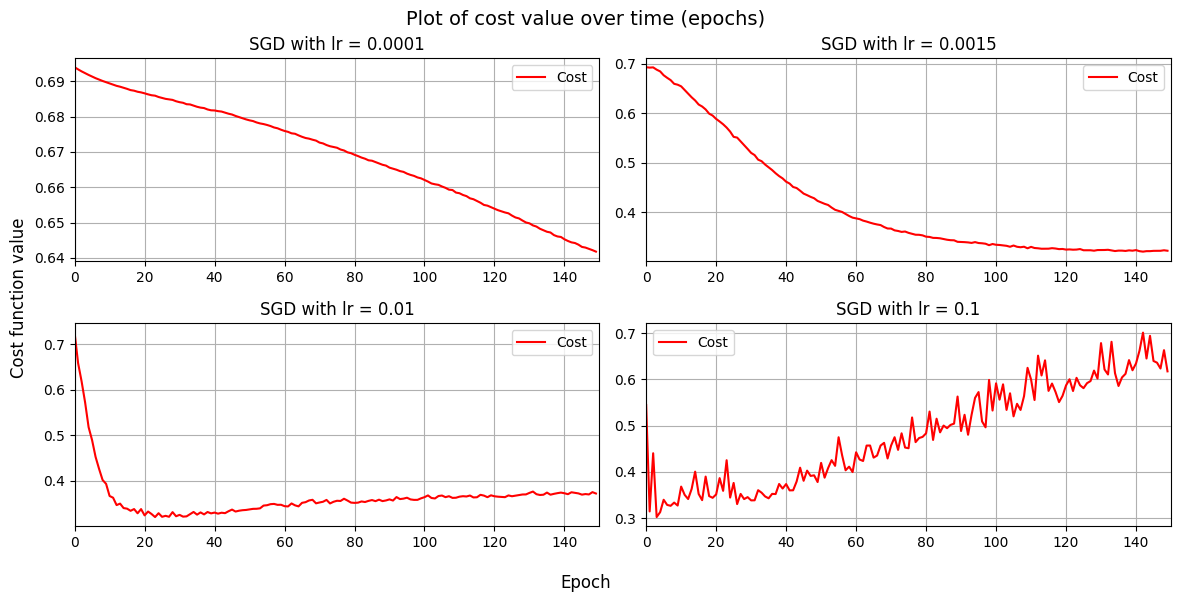

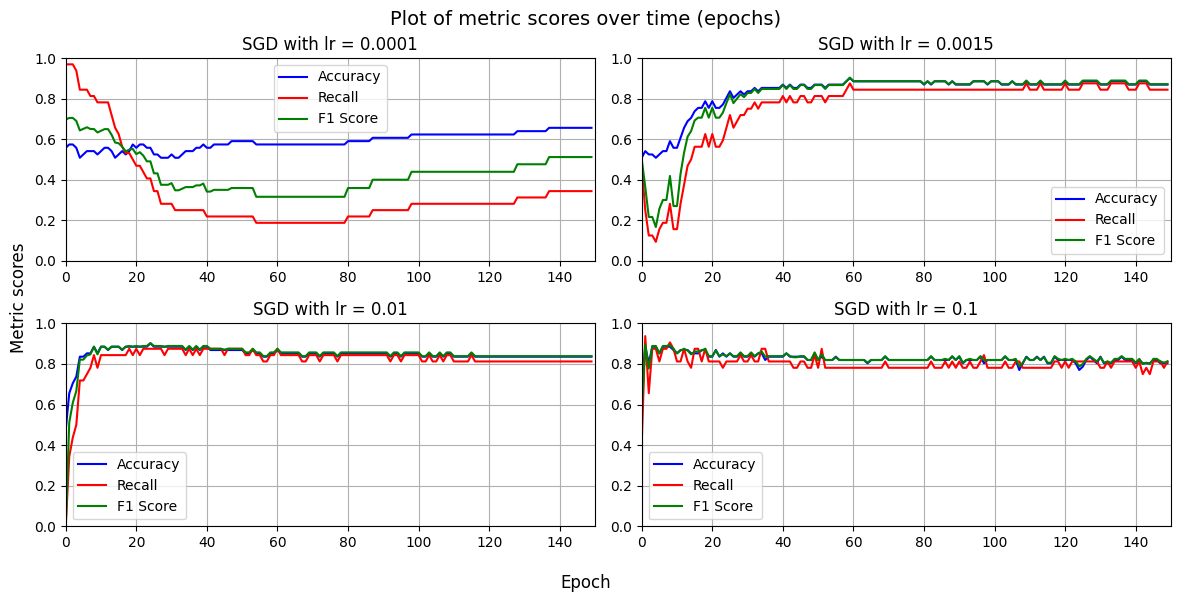

In [58]:
import torch.nn as nn

data = get_data(offline=True)

BATCH_SIZE = 8

train_dataset = HeartDiseaseDataset(data.X_train, data.y_train)
val_dataset = HeartDiseaseDataset(data.X_test, data.y_test)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)


def test_sgd(learning_rates: list[float]) -> list[tuple[dict, str]]:
    results_with_titles = []
    for lr in learning_rates:
        model = HeartDiseaseClassifier(
            input_features=data.X_train.shape[1],
            hidden_layers_config=[
                HiddenLayerConfig(12, nn.Sigmoid())
            ]
        )
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
        results = train_model(
            model=model,
            max_epochs=150,
            train_loader=train_loader,
            val_loader=val_loader,
            loss_fn=nn.BCELoss(),
            optimizer=optimizer,
        )
        results_with_titles.append((results, f"SGD with lr = {lr}"))
    return results_with_titles


results_with_titles = test_sgd(learning_rates=[0.0001, 0.0015, 0.01, 0.1])
compare_plots(results_with_titles, cost=True)
compare_plots(results_with_titles)

Training complete!
Training complete!
Training complete!
Training complete!


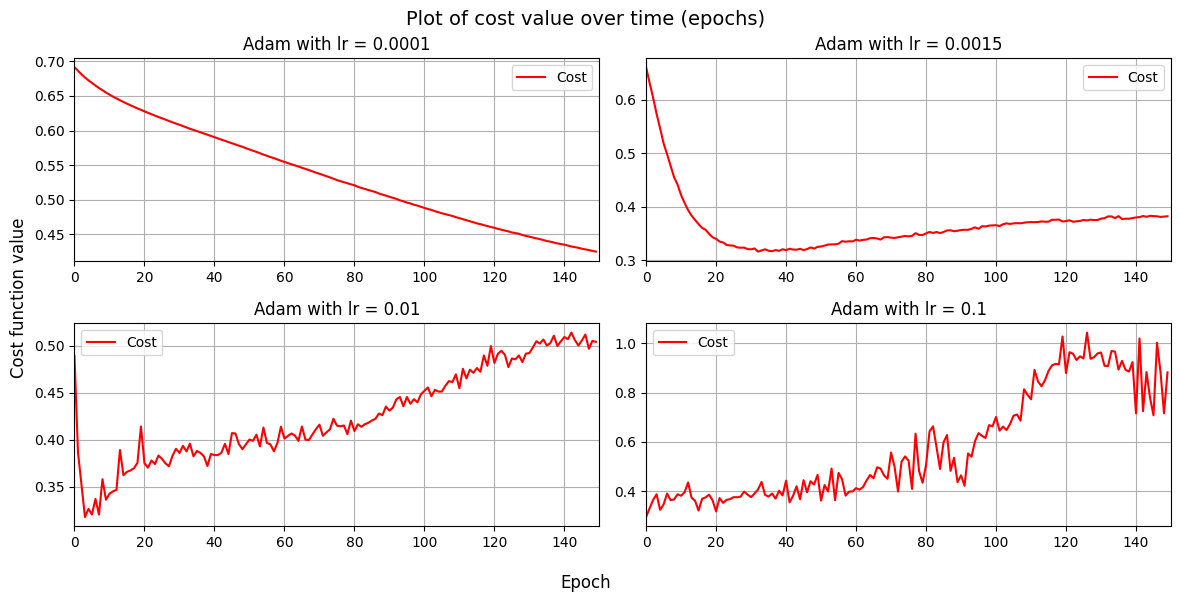

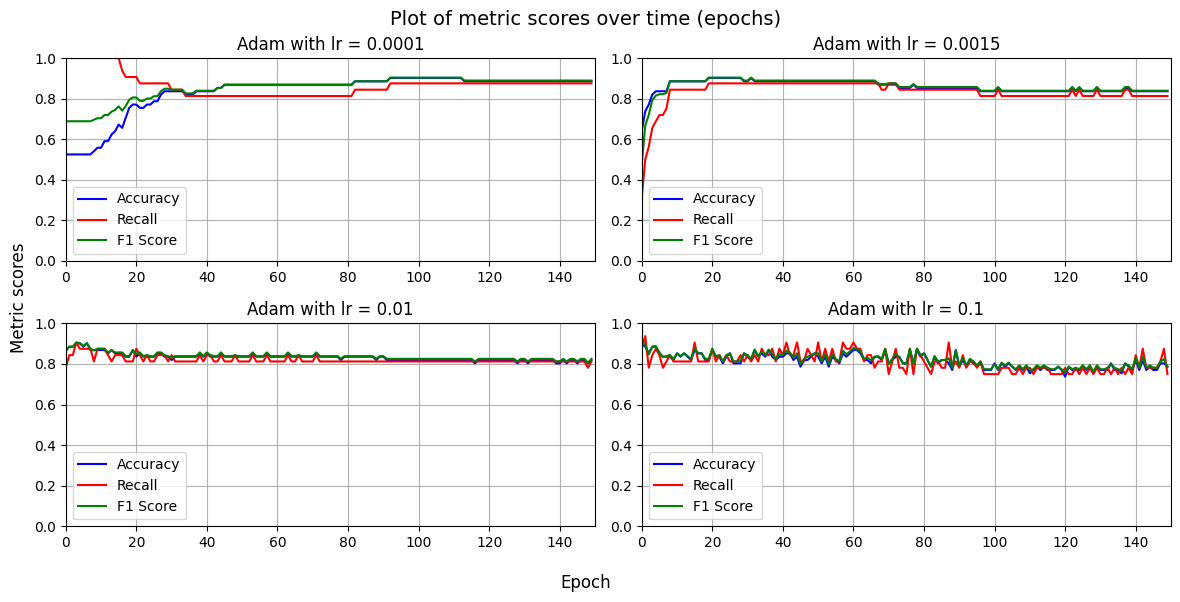

In [59]:
import torch.nn as nn

data = get_data(offline=True)

BATCH_SIZE = 8

train_dataset = HeartDiseaseDataset(data.X_train, data.y_train)
val_dataset = HeartDiseaseDataset(data.X_test, data.y_test)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)


def test_adam(learning_rates: list[float]) -> list[tuple[dict, str]]:
    results_with_titles = []
    for lr in learning_rates:
        model = HeartDiseaseClassifier(
            input_features=data.X_train.shape[1],
            hidden_layers_config=[
                HiddenLayerConfig(12, nn.Sigmoid())
            ]
        )
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        results = train_model(
            model=model,
            max_epochs=150,
            train_loader=train_loader,
            val_loader=val_loader,
            loss_fn=nn.BCELoss(),
            optimizer=optimizer,
        )
        results_with_titles.append((results, f"Adam with lr = {lr}"))
    return results_with_titles


results_with_titles = test_adam(learning_rates=[0.0001, 0.0015, 0.01, 0.1])
compare_plots(results_with_titles, cost=True)
compare_plots(results_with_titles)

Training complete!
Training complete!
Training complete!
Training complete!


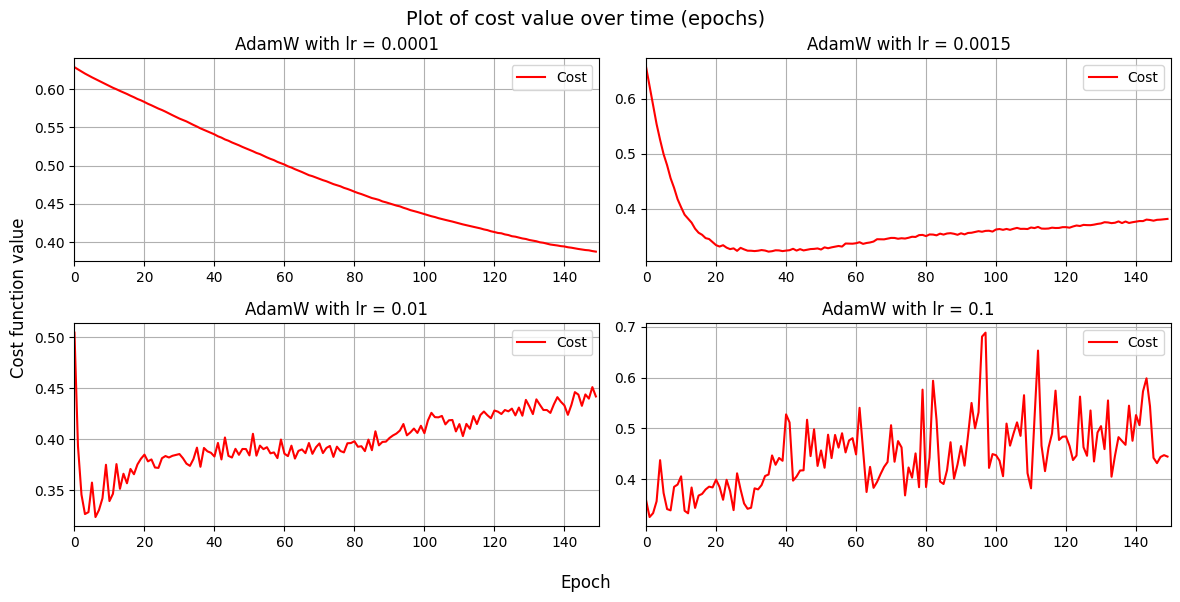

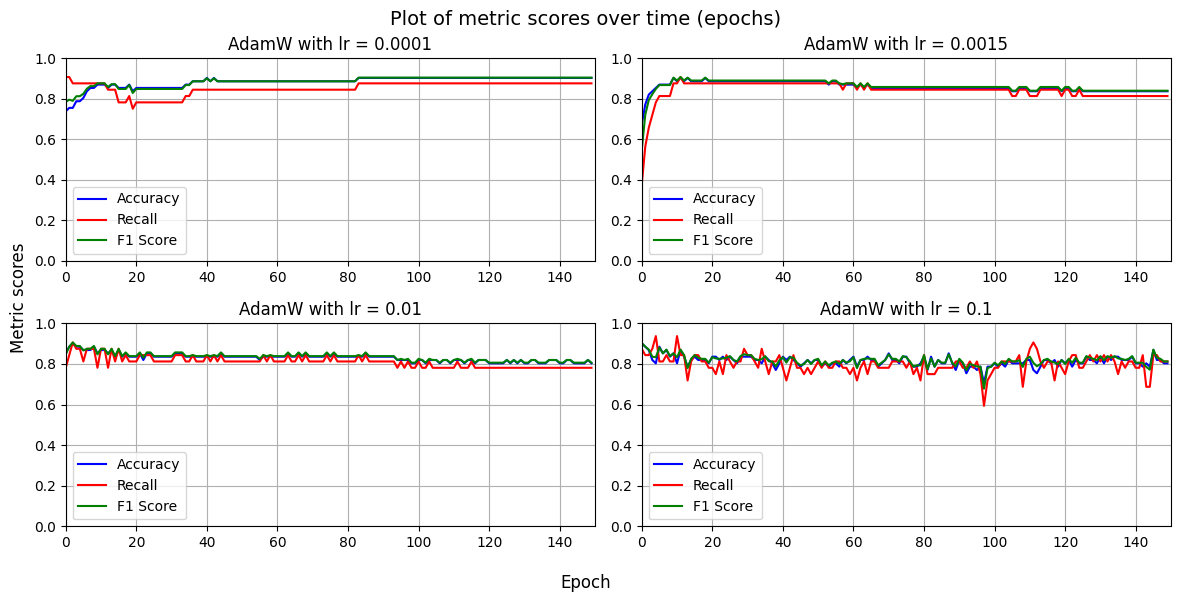

In [60]:
import torch.nn as nn

data = get_data(offline=True)

BATCH_SIZE = 8

train_dataset = HeartDiseaseDataset(data.X_train, data.y_train)
val_dataset = HeartDiseaseDataset(data.X_test, data.y_test)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)


def test_adamw(learning_rates: list[float]) -> list[tuple[dict, str]]:
    results_with_titles = []
    for lr in learning_rates:
        model = HeartDiseaseClassifier(
            input_features=data.X_train.shape[1],
            hidden_layers_config=[
                HiddenLayerConfig(12, nn.Sigmoid())
            ]
        )
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
        results = train_model(
            model=model,
            max_epochs=150,
            train_loader=train_loader,
            val_loader=val_loader,
            loss_fn=nn.BCELoss(),
            optimizer=optimizer,
        )
        results_with_titles.append((results, f"AdamW with lr = {lr}"))
    return results_with_titles


results_with_titles = test_adamw(learning_rates=[0.0001, 0.0015, 0.01, 0.1])
compare_plots(results_with_titles, cost=True)
compare_plots(results_with_titles)

#### Analysis

Looking at these plots we can make the following observations:
- `lr = 0.0001` is too small for all optimizers. The training seems to be quite stable but inefficient.
- `lr = 0.0015` is the best of all optimizers (slightly too high for Adam and AdamW, but the best overall). It provides a solid balance of performance and achieves high metrics.
- `lr = 0.01` is slightly too high for SGD and definitely too high for both Adam and AdamW.
- `lr = 0.1` is too high for any optimizer.

We can conclude that the right choice of learning rate depends strongly on the choice of optimizer.